# Refresher

![title](SVM4.png)

![title](SVM1.png)

![title](SVM2.png)

### Create a cost function:
    
J(w) = $\lambda$*$||w||^2$ + $1/n$*$\sum_{i=1}^{n}$max(0, 1-$y_i(w.x_i + b)$)

The first part is to force the magnitude of weights to get minimized - in order to maximize the worst margin

$\frac{1}{||w||^2}$

This indeed means that hard margin SVM tries to minimize ∥w∥2. Due to the formulation of the SVM problem, the margin is 1/∥w∥. As such, minimizing the norm of w is geometrically equivalent to maximizing the margin. Exactly what we want!

The second part is called "Hing Loss" and we use in the SOft margin SVM

since if the training example lies outside the margin ξi will be zero and it will only be nonzero when training example falls into margin region, and since hinge loss is always nonnegative, it happens we can rephrase our problem as

$max(0, 1-y_i(w.x_i + b))$

So if:

- $y_i$*($w^Tx + b$) $\geq$ 1:
        The we dont have the hing loss and only want to minimize the maginitude of w
        
        
- else:

J(w) = $\lambda$*$||w||^2$ + $1/n$*$\sum_{i=1}^{n}$max(0, 1-$y_i(w.x_i + b)$)

### Gradients:

if:
- $y_i$*($w^Tx + b$) $\geq$ 1:

$\frac{dJ}{dw_k}$ = $2\lambda.w_k$
        
- else:

$\frac{dJ}{dw_k}$ = $2\lambda w_k$ -$y_i.x_i$

$\frac{dJ}{db}$ = $-y_i$

### Update rules: GD

$ w = w - \alpha.dw$

$ b = b - \alpha.db$ 

## Hard margin

###  Solving using Sequential least squares programing (SLSQP)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from svm_utils import *
from sklearn import datasets

In [ ]:
class HardMarginSVM:
    def __init__(self, learning_rate = 0.0001, lambda_param = 0.001, n_iters = 1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        y_ = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.learning_rate * (-y_[idx])
    
    def predict(self, X):
        pred_ = np.dot(X, self.w) + self.b
        return np.sign(pred_)

In [ ]:
X, y = datasets.make_blobs(n_samples = 1000, n_features = 2, centers = 2, cluster_std = 1.005, random_state = 40)
clf = HardMarginSVM()
clf.fit(X, y)
print(clf.w, clf.b)

[0.72402009 0.22902191] 0.06530000000000084


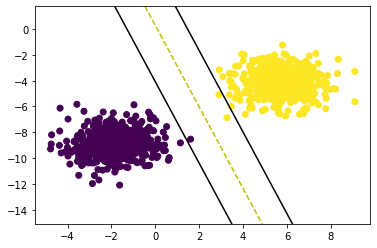

In [ ]:
visualize_svm(X, y, clf)

In [ ]:
from scipy import optimize
from sklearn import svm
import seaborn as sns

In [ ]:
N = 1000
nFeatures = 2
X, y = generateBatchBipolar(N, sigma = 0.4)

In [ ]:
y[:, np.newaxis].shape

(1000, 1)

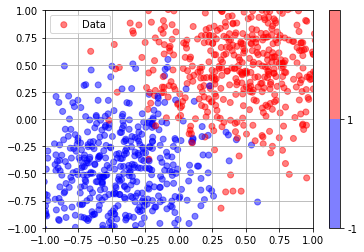

In [ ]:
plotSvm(X, y)

In [ ]:
from scipy.optimize import Bounds

In [ ]:
class SoftMarginSVM:
    def __init__(self, C):
        self.C = C
        
    def fit(self, X, y):
        N = len(y)
        Xy = X * y[:, np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)
        
        def ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))
    
        def derivativeLd0(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)
        
        alpha = np.ones(N)
        bounds_alpha = Bounds(np.zeros(N), np.full(N, self.C))
        
        constraints = ({'type' : 'eq',
                        'fun' : lambda a:np.dot(a, y),
                       'jac' : lambda a: y})
        optRes = optimize.minimize(fun = lambda a: -ld0(GramXy, a),
                                   x0 = alpha,
                                   jac = lambda a : -derivativeLd0(GramXy, a),
                                   constraints = constraints,
                                   bounds = bounds_alpha)
        self.alpha = optRes.x
        
        self.w = np.sum((self.alpha[:, np.newaxis]* Xy), axis = 0)
        
        epsilon = 1e-4
        
        self.supportVectors = X[self.alpha > epsilon]
        self.supportLabels = y[self.alpha > epsilon]
        
        b = []
        for i in range(len(self.supportVectors)):
            b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T, self.w)
            b.append(b_i)
        
        self.intercept = sum(b) / len(b)

In [ ]:
model = SoftMarginSVM(C = 5)
model.fit(X, y)

Number of support vectors = 108


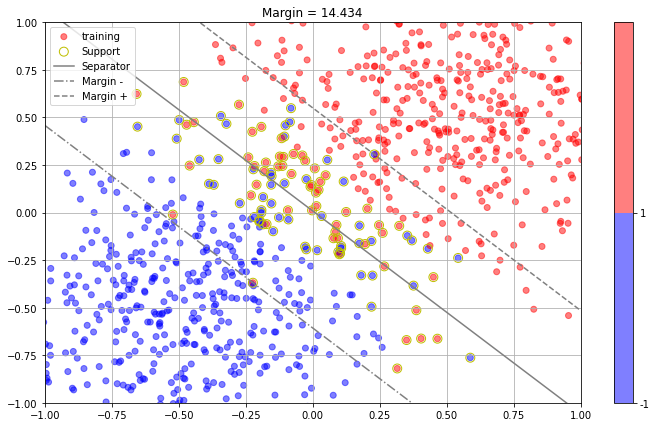

In [ ]:
fig, ax = plt.subplots(1, figsize = (12, 7))
plotSvm(X, y, model.supportVectors, model.w, model.intercept, label = 'training', ax=ax)

In [ ]:
model1 = svm.SVC(kernel = 'linear', C = 5)
model1.fit(X,y)

SVC(C=5, kernel='linear')

Number of support vectors = 107


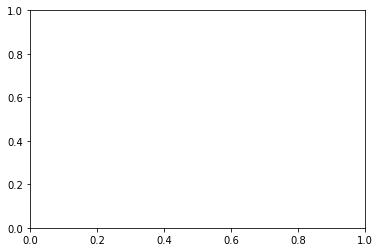

In [ ]:
plotSvm(X, y, model1.support_vectors_, model1.coef_[0], model1.intercept_[0], label = 'training', ax=ax)

In [ ]:
fx_i = x[i] @ np.sum(alpha * y[:, np.newaxis] * x, axis=0) + b
e_i = fx_i - y[i]